# Applications of Data Science

# Lab 1

# Exploring Time Series Data

## Overview

Time series models are used in a wide range of applications, particularly for forecasting. 

This notebook contains lab material to familarize yourself with key aspects of time series analysis. You will perform analyses on a time series of California dairy data. Specifically, you will explore the structure of the time series and forecast the monthly production of fresh milk in the state of California. 

This exploration is performed in two steps:

- Explore the characteristics of the time series data.
- Decompose the time series of monthly milk production into trend, seasonal components, and remainder components. 
- Apply time series models to the remainder component of the time series.
- Forecast the production of monthly milk production for a 12 month period. 

## What you will need

To complete this lab, you will need the following:

- A web browser and Internet connection 
- An Azure Machine Learning workspace
- The lab files for this lab

**Note** To set up the required environment for the lab, follow the instructions in the [Setup guide](https://aka.ms/edx-dat203.3x-setup). 


# to avoid problems with loaing and installig R packages, this lab was executed on a local machine 'anaconda distribution', than uploaded to AzureML 

## Load and Examine the Data

As a first step, ensure that you have uploaded the **cadairydata.csv** file as a new dataset in your Azure Machine Learning workspace, and then execute the code below to load the data set into a dataframe.

In [2]:
to.POSIXct <- function(year, monthNumber){
  ## Function to create a POSIXct time series 
  ## object from a year.month format
  
  ## Create a character vector from the numeric input
  dateStr <- paste(as.character(year), "-",
                   as.character(monthNumber), "-",
                   "01", sep = "")
  ## Return the POSIXct time series object
  as.POSIXct( strptime(dateStr, "%Y-%m-%d"))
}

order.month <- function(x){
  ## Function to make Month column an ordered factor.
  x <- substr(x, 1, 3) ## Use just the first three letters
  factor(x, levels = c("Jan", "Feb", "Mar", "Apr", "May", "Jun","Jul", "Aug", "Sep", "Oct", "Nov", "Dec"),
         ordered = TRUE)
}

read.dairy <- function(dataSet = 'cadairydata.csv'){
  ##library("AzureML")
  #ws <- workspace()

  df <- read.csv('cadairydata.csv')

    #download.datasets(ws, dataSet)
  df$dateTime <- to.POSIXct(df$Year, df$Month.Number)

  dropCols <- c("X","Year.Month", "Month.Number")

  df$Month <- order.month(df$Month)

  df[ , !(names(df) %in% dropCols)]

}

dairy <- read.dairy()

The code you just executed performs the following steps:

- The data is read from a dataset in your Azure Machine Learning subscription.
- A new column, of type POSIXct, is created. POSIXct is a flexible R data-time class. The **strtime** function formats a text string for conversion to the date-time class. 
- The **Month** column is converted to an ordered R factor class. 
- Some unnecessary columns are removed from the data frame.

Next, execute the code below and examine the head of the data frame.

In [3]:
head(dairy)

Year,Month,Cotagecheese.Prod,Icecream.Prod,Milk.Prod,N.CA.Fat.Price,dateTime
1995,Jan,4.370,51.595,2.112,0.9803,1995-01-01
1995,Feb,3.695,56.086,1.932,0.8924,1995-02-01
1995,Mar,4.538,68.453,2.162,0.8924,1995-03-01
1995,Apr,4.280,65.722,2.130,0.8967,1995-04-01
1995,May,4.470,73.730,2.227,0.8967,1995-05-01
1995,Jun,4.238,77.994,2.124,0.9160,1995-06-01


The data frame inlcudes **Year**, **Month**, and the **dateTime** column with calendar information. Other columns show the production of dairy products and a benchmark price for milk fat.

Next, examine the class of the **dateTime** column. 

In [4]:
class(dairy$dateTime)

[1] "POSIXct" "POSIXt"

As expected, this column is of class **POSIXct**, which inherits from the R **POSIXt** class. 

Now, examine the first 20 values of the **dateTime** column.

In [5]:
dairy$dateTime[1:20]

 [1] "1995-01-01 WET" "1995-02-01 WET" "1995-03-01 WET" "1995-04-01 WET"
 [5] "1995-05-01 WET" "1995-06-01 WET" "1995-07-01 WET" "1995-08-01 WET"
 [9] "1995-09-01 WET" "1995-10-01 WET" "1995-11-01 WET" "1995-12-01 WET"
[13] "1996-01-01 WET" "1996-02-01 WET" "1996-03-01 WET" "1996-04-01 WET"
[17] "1996-05-01 WET" "1996-06-01 WET" "1996-07-01 WET" "1996-08-01 WET"

Note that these values inlcude the day and a time zone.

You can perform both arithmetic and logical operations on POSIXct objects. As an example, select the last 12 months of dairy data by executing the next code cell. 

In [6]:
dairy[dairy$dateTime > '2012-12-01',]

,Year,Month,Cotagecheese.Prod,Icecream.Prod,Milk.Prod,N.CA.Fat.Price,dateTime
NA,NA,NA,NA,NA,NA,NA,NA
NA.1,NA,NA,NA,NA,NA,NA,NA
217,2013,Jan,2.282,62.612,3.462,1.7744,2013-01-01
218,2013,Feb,1.941,66.274,3.231,1.6224,2013-02-01
219,2013,Mar,2.150,75.770,3.676,1.6968,2013-03-01
220,2013,Apr,2.217,76.396,3.622,1.7444,2013-04-01
221,2013,May,2.341,80.899,3.720,1.8552,2013-05-01
222,2013,Jun,2.694,92.091,3.489,1.8314,2013-06-01
223,2013,Jul,2.433,84.026,3.373,1.6923,2013-07-01
224,2013,Aug,2.169,78.382,3.400,1.6273,2013-08-01


Try selecting some other subsets of these data using the **POSIXct** column. 

## Create a Time Series Plot

Now that you have examined the data frame, you will create a time series plot of milk production. When creating a time series plot, the **POSIXct** column is used to create the time axis. 

The plot is created using the **ggplot2** package. Execute the code in the cell below to create the time series plot of milk production. 

Loading required package: ggplot2
Warning message:
"Removed 2 rows containing missing values (geom_path)."

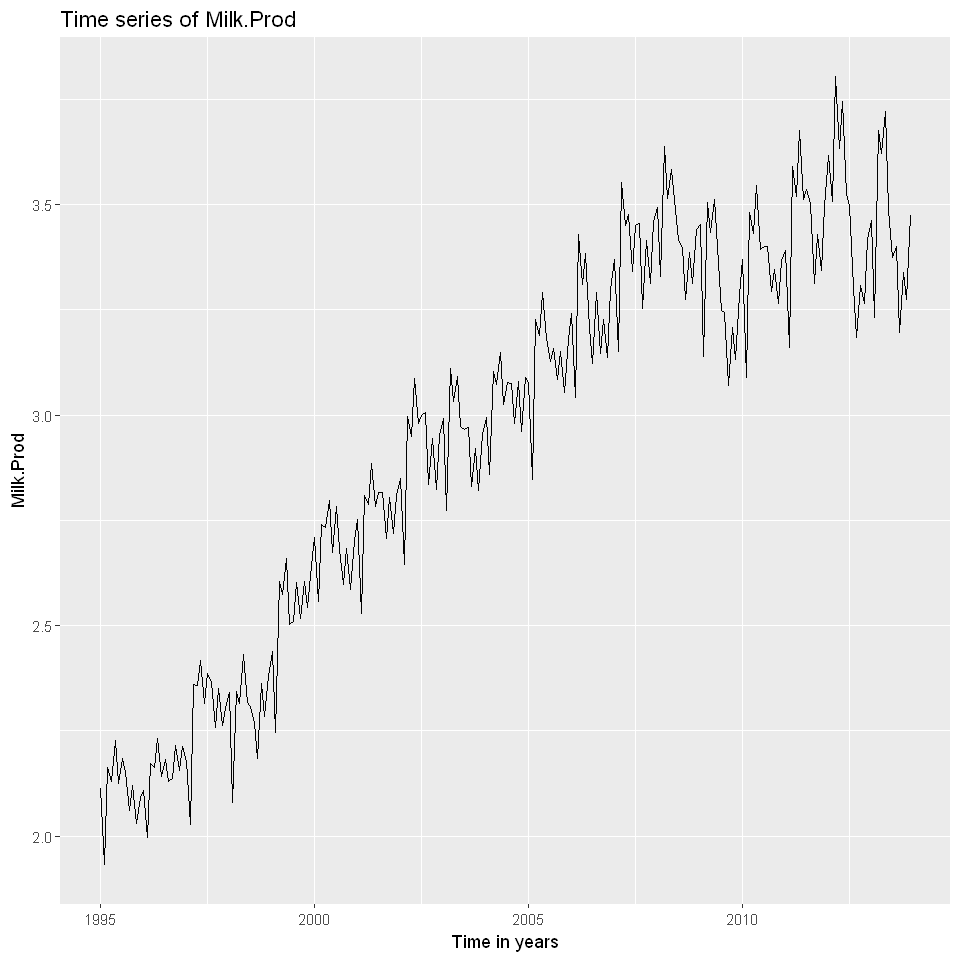

In [7]:
library(repr)
options(repr.plot.width=8, repr.plot.height=8)

dairy.plot <- function(df, col = 'Milk.Prod'){
  require(ggplot2)
  ggplot(df, aes_string('dateTime', col)) +
    geom_line() +
    ggtitle(paste('Time series of', col)) +
    xlab('Time in years')
}
dairy.plot(dairy)

The production of milk is shown on the vertical scale and the date is on the horizontal scale. 

For most of the time period shown, the production of milk increased year over year. However, there is a decline in milk production starting in 2009 as a results of the recession. Also, notice that this time series exhibits a strong seasonal component with an annual cycle. 


## Statistical Properties of the Time Series

Having examined the time series of milk production, you will now explore some statistical properties of the time series. 

Autocorrelation is a fundamental property of time series. The **Autocorrelation Function** or ACF provides information on the dependency of the time series values of previous values. Later in this lab, you will use the results of a ACF analysis to estimate the order of moving average processes.The **Partial autocorrelation Function** or PACF, measures the correlation of the time series with its own lag values. Later in this lab you will use an  PACF to estimate the order of an autoregressive process. 

Execute the code in the following cell and examine the ACF of the milk production time series. 

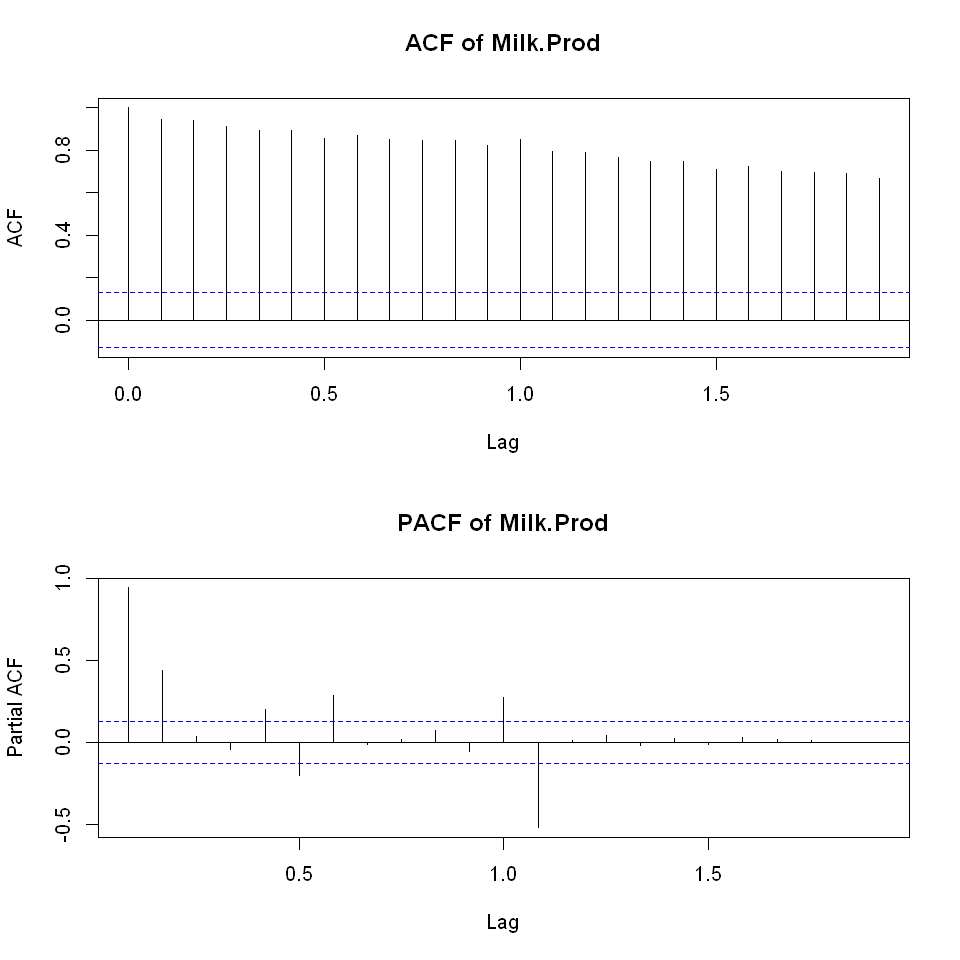

In [8]:
dairy.acf <- function(df, col = 'remainder', is.df =TRUE){
  if(is.df) temp <- df[, col]
  else temp <- df
  temp = ts(temp, start = 1995, frequency = 12)
  par(mfrow = c(2,1))
  acf(temp, main = paste('ACF of', col))
  pacf(temp, main = paste('PACF of', col))
  par(mfrow = c(1,1))
}
dairy.acf(dairy, col = 'Milk.Prod')

Note that the values of the ACF at the various lags decays only slowly. This indicates there is considerable serial correlation between the time series values at the various lags, mostly likely from the trend. 

Plotting a histogram provides information on the distribution of values of the time series. Execute the code in the cell below and examine the histogram.

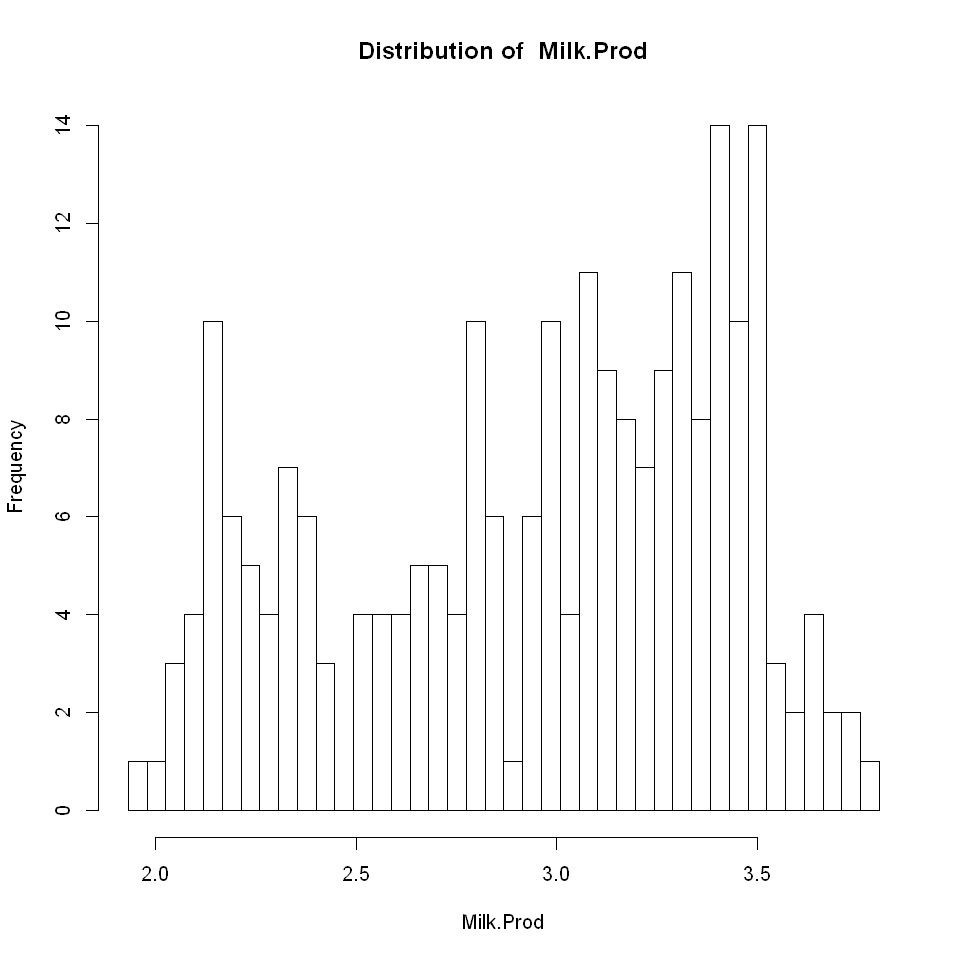

In [9]:
hist.ts = function(df, col = 'Milk.Prod', bins = 40){
    temp = df[,col]
    breaks = seq(min(temp), max(temp), length.out = (bins + 1))
    hist(temp, breaks = breaks, main = paste('Distribution of ', col), xlab = col)
}
hist.ts(dairy)

The histogram of the full milk production time series shows considerable dispursion. Again this behavior is likely the result of the trend. 


### Exercise: Plot Ice Cream Production

In this exercise you will use the **Icecream.Prod** column of the **diary** data frame. Create plots to answer the following questions. 

- Does icecream production have a noticable seasonal component? Can you characterize the trend of ice cream production greater over time as strong or weak? 
- Is the seasonal variation of icecream production noticable in the plot of ACF? Does the ACF plot indicate a strong trend component? 

In the code cell below, use the **dairy.plot** and **dairy.acf** functions to create new plots showing the ice cream production and answer the questions above. 


Warning message:
"Removed 2 rows containing missing values (geom_path)."

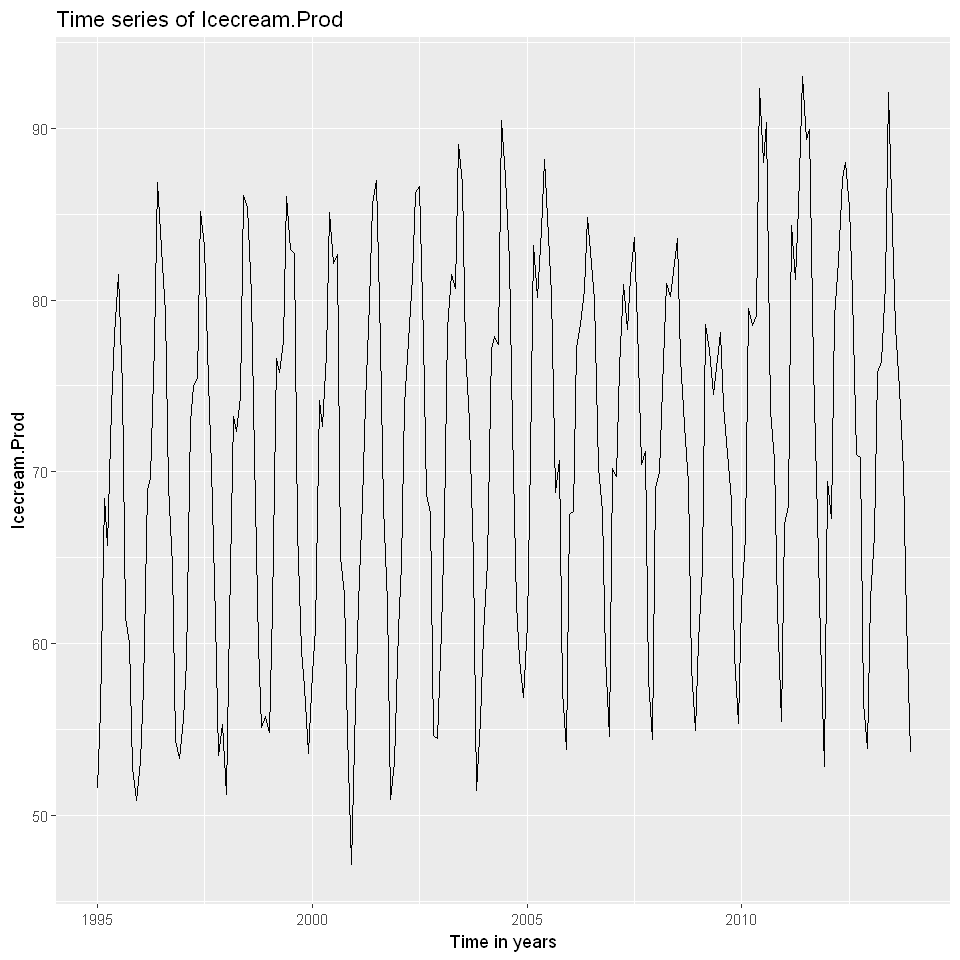

In [10]:
dairy.plot(dairy, 'Icecream.Prod')

## Simple Moving Average Decomposition of the Time Series

Time series are typically decomposed into three components: trend, seasonal, and the remainder, or residual. Trend can be modeled by several methods. You will start by decomposing the time series using a simple moving average model. 

The code in the cell below uses moving window method to compute the average of the time series over specified span, or order of the operator. As the moving window operator moves over the data, the average of the values in the windows is calculated. Execute the cell to load the function.

In [11]:
dairy.ma <- function(df, col = 'Milk.Prod', order = 12){
  temp = df[, col]
  end = length(temp) - 1
  out = rep(0, length(temp))
  out[1] = temp[1]
  for(i in 1:end){
    if(i - order <= 1) j = 1 
    else j = j + 1
    out[i + 1] = sum(temp[j:i])/(i - j + 1)
  }
  out
}

Once the trend has been removed, the seasonal component must be modeled and removed. The function in the cell below computes the seasonal component as a function of the month of the year using a linear model. The **0** in the model formula supresses the intercept term. Since 12 monthly factors are used to model seasonal variation, the model would be over-determined if an intercept was included. 

Execute the code in the cell to load the function.

In [12]:
dairy.seasons <- function(df, col = 'Milk.Prod'){
  df$y = df[, col]
  fit = lm(y ~ 0 + Month, data = df)
  predict(fit, newdata = df)
}

Using these functions you will now decompose the time series into its components. The function in the code cell below uses multiplicative decomposition of the time series. The model is transformed to a multiplicative model by taking the log of the time series values. The moving average is computed over a twelve month moving window. 

Execute the code in the cell below and examine the head of the resulting data frame. 

In [13]:
decomp.dairy <- function(df,  col = 'Milk.Prod', multiplicative = TRUE, order = 12){
  if(multiplicative) {
    temp = log(df[, col])
    df[, col] = temp
  } else { 
    temp = df[, col] 
  }
  trend = dairy.ma(df, col = col, order = order)
  temp = temp - trend
  df[, col] = temp
  seasonal = dairy.seasons(df, col = col)
  remainder = temp - seasonal
  data.frame(trend = trend, seasonal = seasonal, remainder = remainder)
}
decomp <- decomp.dairy(dairy, order = 12)
head(decomp)

trend,seasonal,remainder
0.7476354,0.02471208,-2.471208e-02
0.7476354,-0.04996016,-3.911947e-02
0.7030956,0.06783954,9.862991e-05
0.7257416,0.03872409,-8.343715e-03
0.7333367,0.06733682,-1.813267e-05
0.7468004,0.01530435,-8.803681e-03


The resulting data frame has three components for trend, seasonal, and remainder.

The code in the cell below creates visualizations of each of the three components of the decomposition of the time series using **ggplot2**. Run the code in the cell to visualize these components. 

(**Note**: If an error occurs stating that gridExtra can't be found, save the notebook, halt and close it, reopen it, run all the cells above this one, and then re-run the cell below - occasionally newly installed packages fail to load in a timely fashion) 

Loading required package: gridExtra
Warning message:
"package 'gridExtra' was built under R version 3.4.3"

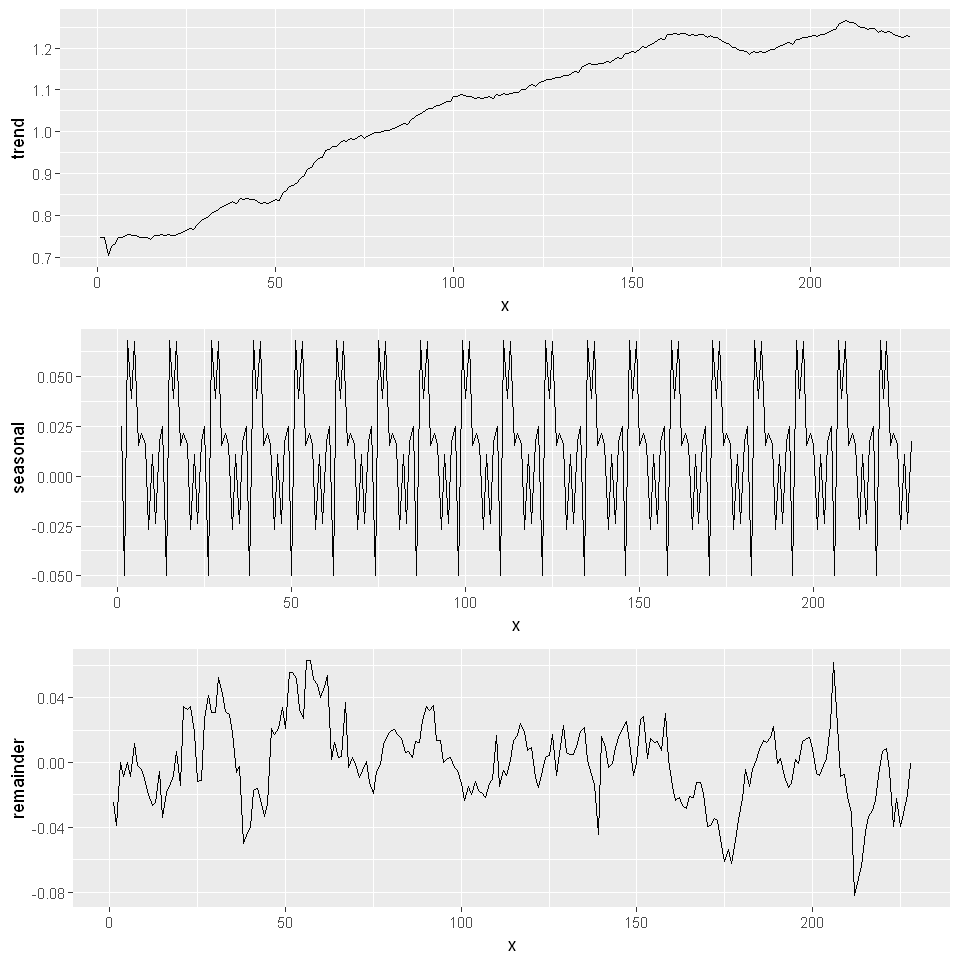

In [18]:
decomp.plot <- function(df){
  require(ggplot2)
  #install.packages("gridExtra", repos='http://cran.us.r-project.org')
  require(gridExtra)
  df$x = 1:nrow(df)
  ycols = c('trend', 'seasonal', 'remainder')
  p <- lapply(ycols, function(y){
               ggplot(df, aes_string('x', y)) + 
                         geom_line() +
                         ylab(y)
            })
  grid.arrange(p[[1]], p[[2]], p[[3]], nrow = 3)
}
decomp.plot(decomp)

In [16]:
install.packages("forecast", repos='http://cran.r-project.org/',dependencies = TRUE)

Installing package into 'C:/Users/009/Documents/R/win-library/3.4'
(as 'lib' is unspecified)


package 'forecast' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\009\AppData\Local\Temp\Rtmp6VoaUF\downloaded_packages


You can see the trend and seasonal components clearly separated in the above plots. The remainder plot looks fairly random, as expected. But, is the remainder actually stationary?  To test for stationarity of the remainder, plot the ACF by executing the code in the cell below. 

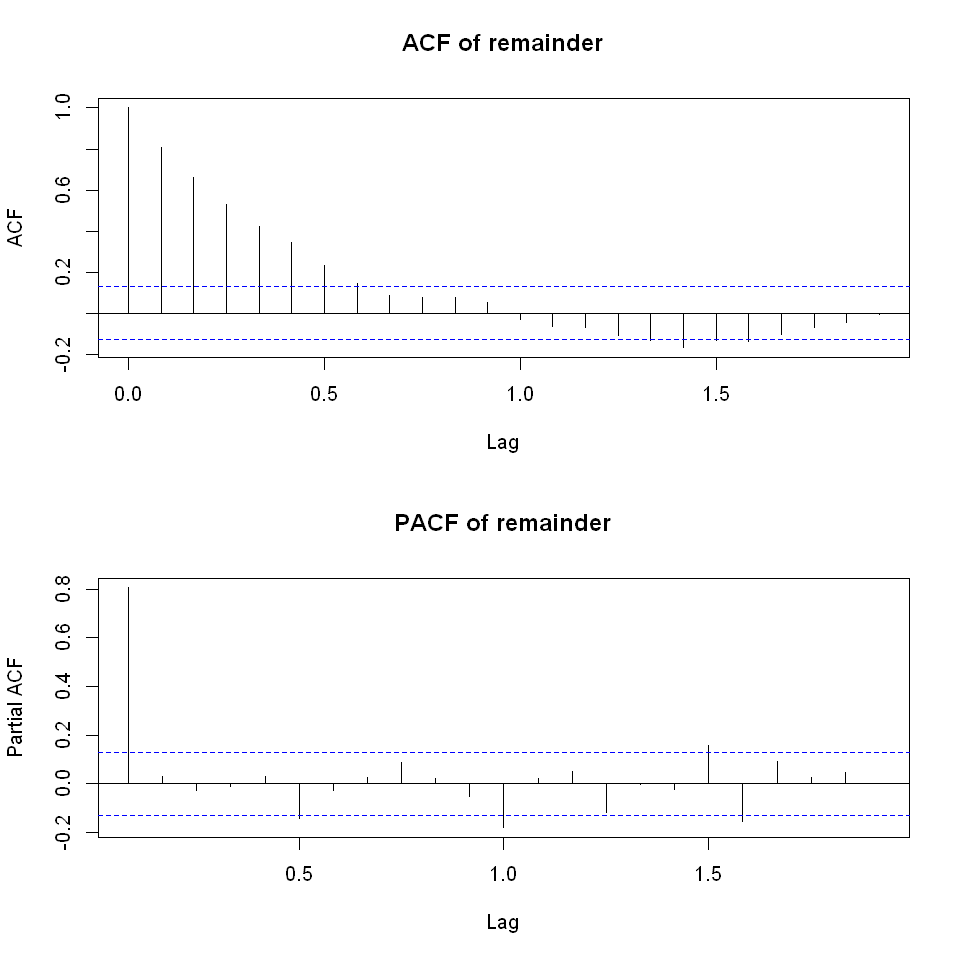

In [19]:
dairy.acf(decomp)

The ACF has 7 significant lag values, indicating the remainder is not, in fact, stationary. 

## Exploring the Multiplicative Model with lowess

Having tried a simple moving average decomposition, you will now use a lowess model to determine the trend. Lowess is a sophisticated non-linear regression. The lowess trend model is combined with a moving window seasonal component model into the R **stl** function.   

The code in the cell below uses **stl** to decompose a time series. Plots are created of the components of the time series. Finally, the columns of the time series decomposition are added as new column to input data frame. Execute the code in the cell below to compute and view a decomposition of the milk production time series. 

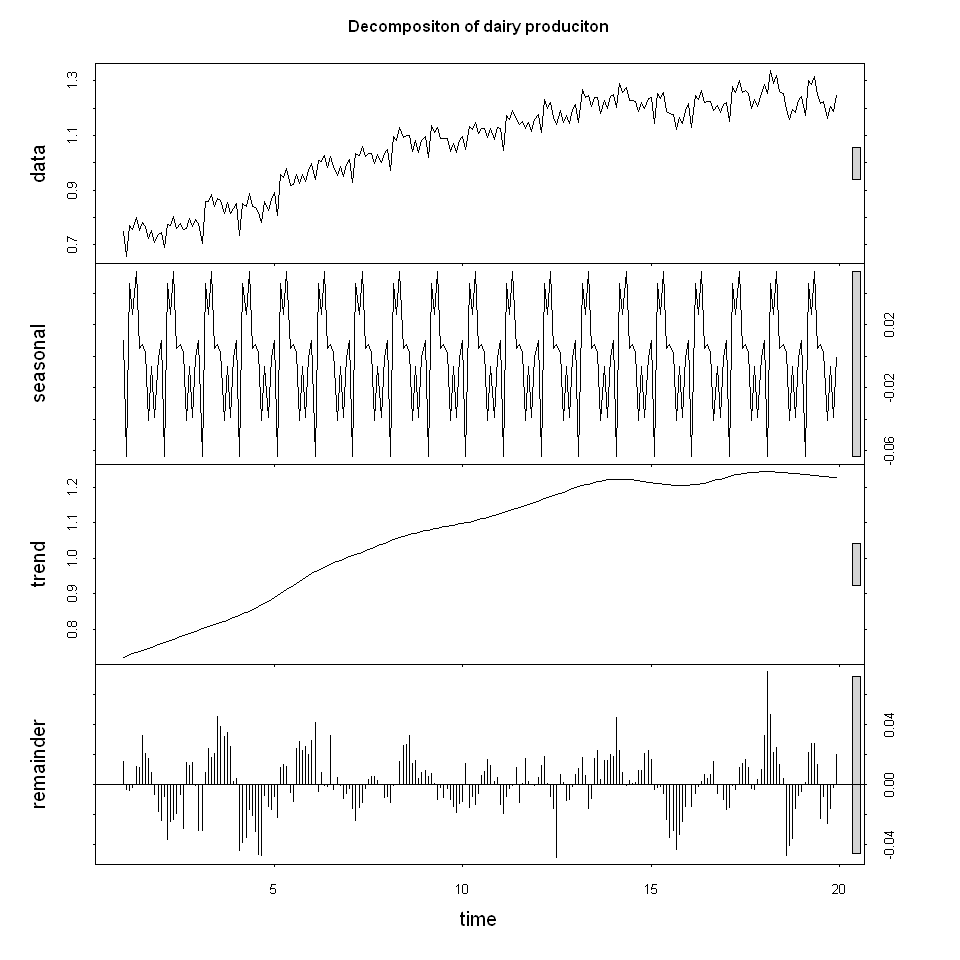

In [20]:
dairy.decomp <- function(df, col = 'Milk.diff', span = 0.5, Mult = TRUE){
  if(Mult) {temp <- ts(log(df[, col]), frequency=12, start=1)
  } else {temp <- ts(df[, col], frequency=24, start=1)}
  span = span * length(temp)  
  dairyFit <- stl(temp, s.window = "periodic", t.window = span)
  plot(dairyFit, main = 'Decompositon of dairy produciton')
  cbind(df, as.data.frame(dairyFit$time.series))
}
dairyMult = dairy.decomp(dairy, col = 'Milk.Prod', span = 0.2)

The time series charts show the original time series along with the components of the decomposition. The trend is a bit smoother than was obtained with the simple moving average decomposition. 

The question remains, is the remainder from this decomposition stationary? To find out, execute the code in the cell below.  

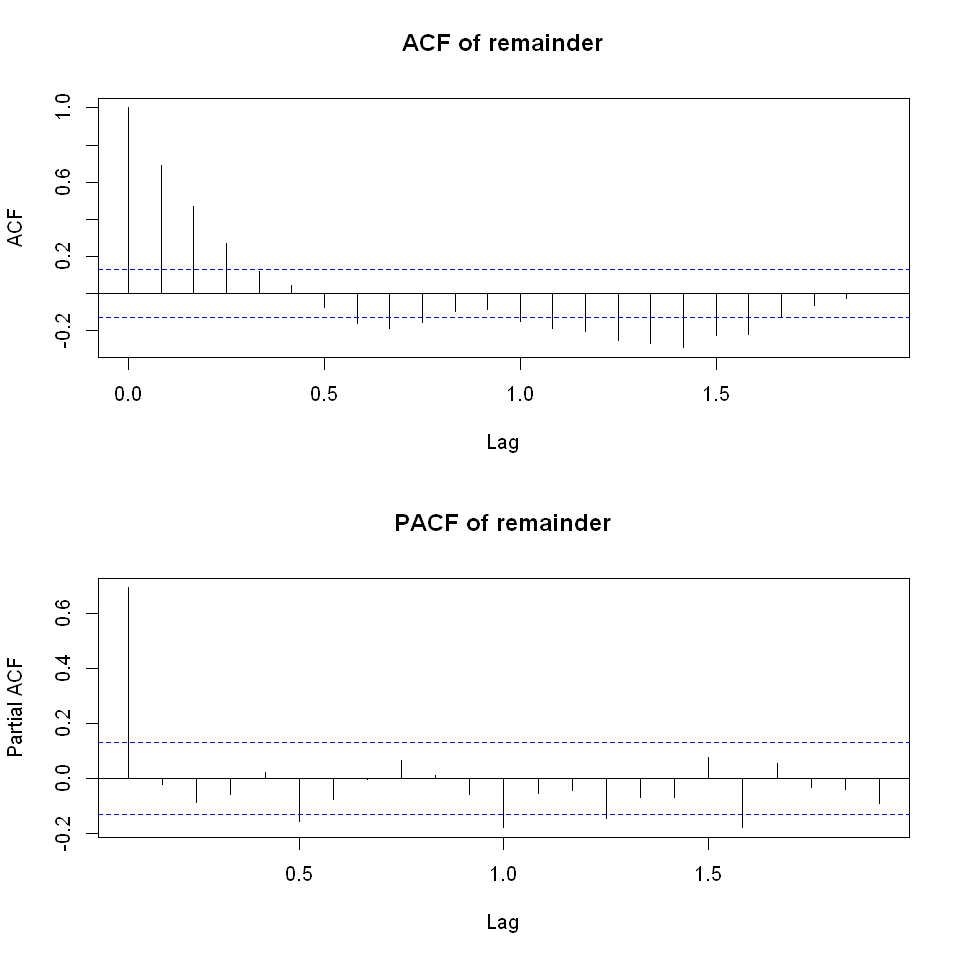

In [21]:
dairy.acf(dairyMult)

The first 4 lag values of the ACF have significant values, indicating that the remainder series is not stationary. Compared to the behavior of the ACF for the simple moving average decomposition, the behavior of the remainder is improved.  

Now, plot the histogram of the remainder by executing the code in the cell below. 

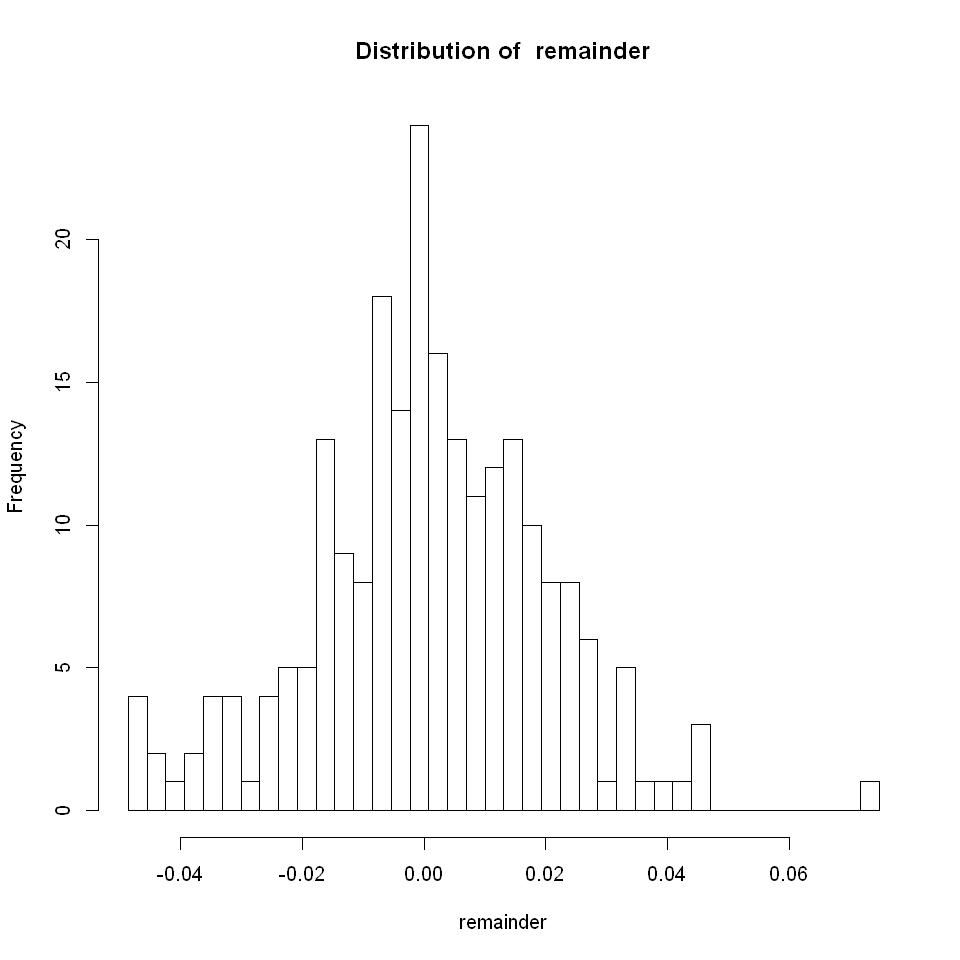

In [22]:
hist.ts(dairyMult, col = 'remainder')

The distribution of the remainder values is much closer to a Normal distribution than for the original time series you created earlier. This result, combined with the ACF plot, indicates that the stl decomposition is effective.  

You will further, investigate the remainder (non-seasonal residual) component by making a box plot by month of the year. The code in the cell below plots a box plot by month of the remainder component using ggplot2. Execute the code in the cell below to display the box plot. 

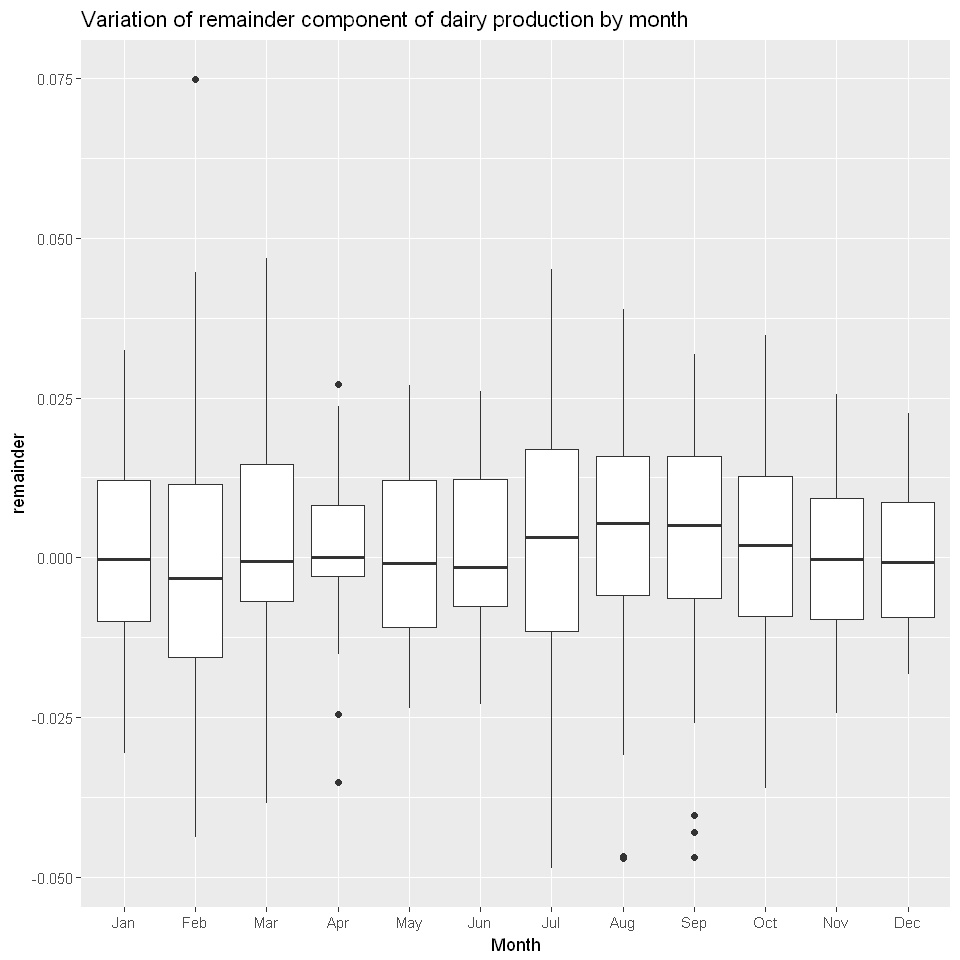

In [23]:
dairy.box <- function(df, col = 'remainder'){
  require(ggplot2)
  p <- ggplot(df, aes_string('Month', col)) +
    geom_boxplot() +
    ggtitle('Variation of remainder component of dairy production by month')
  print(p)
}
dairy.box(dairyMult)

The remainder component shows only limited vairation from month to month. The differences are within the interquartile range, indicating that the seasonal model is a reasonably good fit.  

****

### Exercise: Decomposition of Ice Cream Production Time Series

In this exercise you will decompose the **Icecream.Prod** column of the **diary** data frame. Create plots to answer the following questions. 

- Does icecream production have a noticable seasonal component or are the values all close to the average over time? Is there a strong seasonal component for icecream production. 
- Does the acf plot indicate that the remainder series is stationary?
- Do the values in the histogram have an approximately normal distribution?
- Does the interquartile range for each month overlap, indicating that the decomposition has produced a reasonably good model of the seasonal variation. 

In the code cell below, use the **dairy.decomp**, **dairy.acf**, **dairy.hist**, and **dairy.box** functions to create new plots of the ice cream production time series and answer the questions above. 

****


In [30]:
print(df)

function (x, df1, df2, ncp, log = FALSE) 
{
    if (missing(ncp)) 
        .Call(C_df, x, df1, df2, log)
    else .Call(C_dnf, x, df1, df2, ncp, log)
}
<bytecode: 0x00000000085ca5e0>
<environment: namespace:stats>


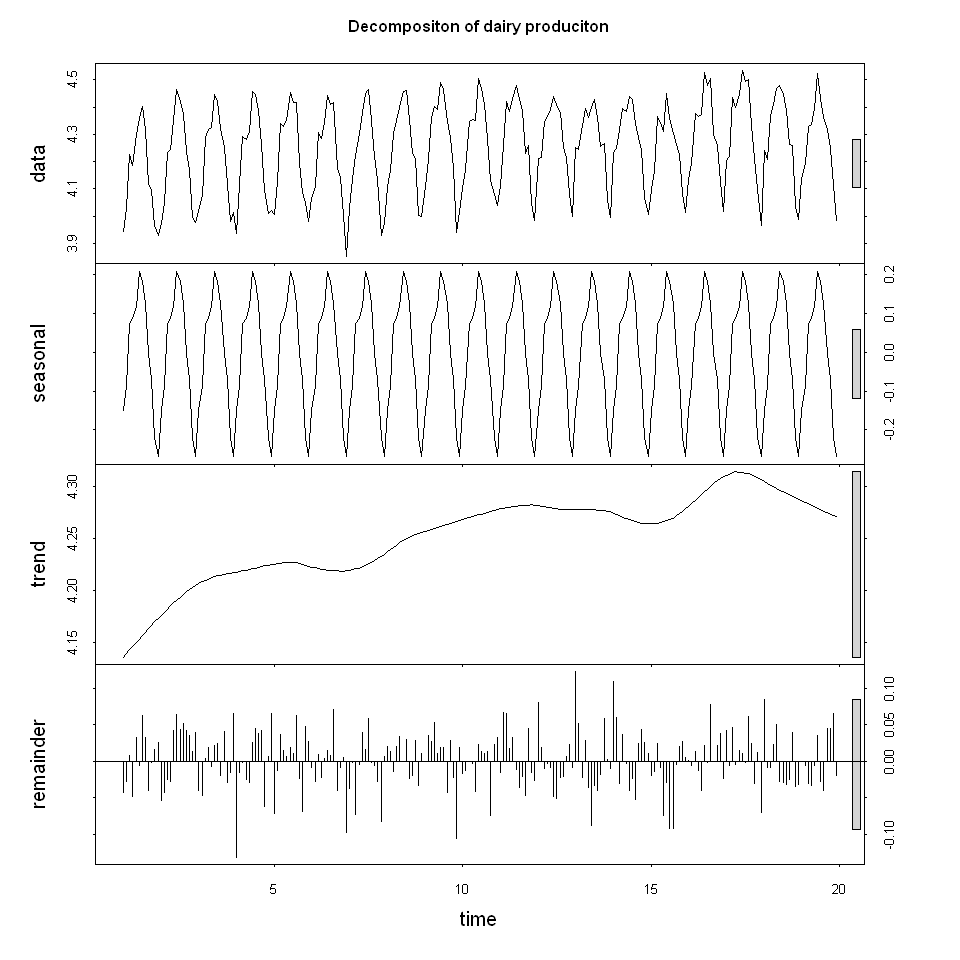

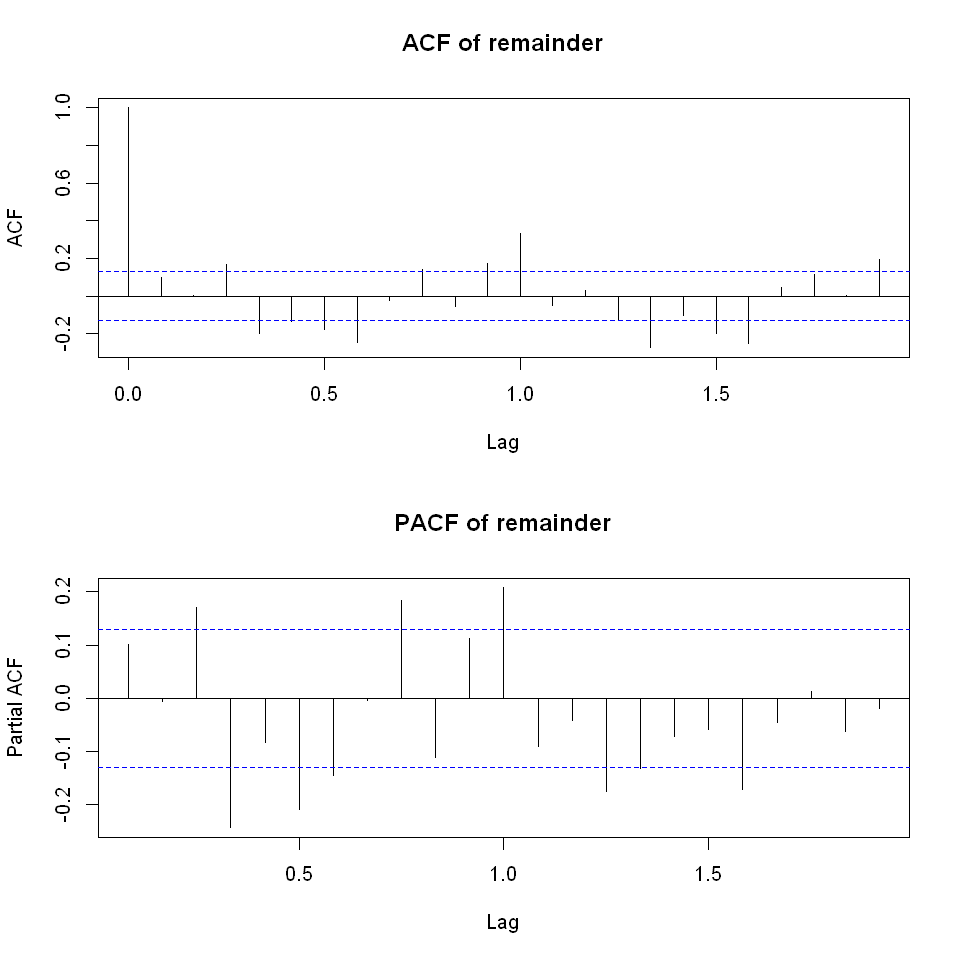

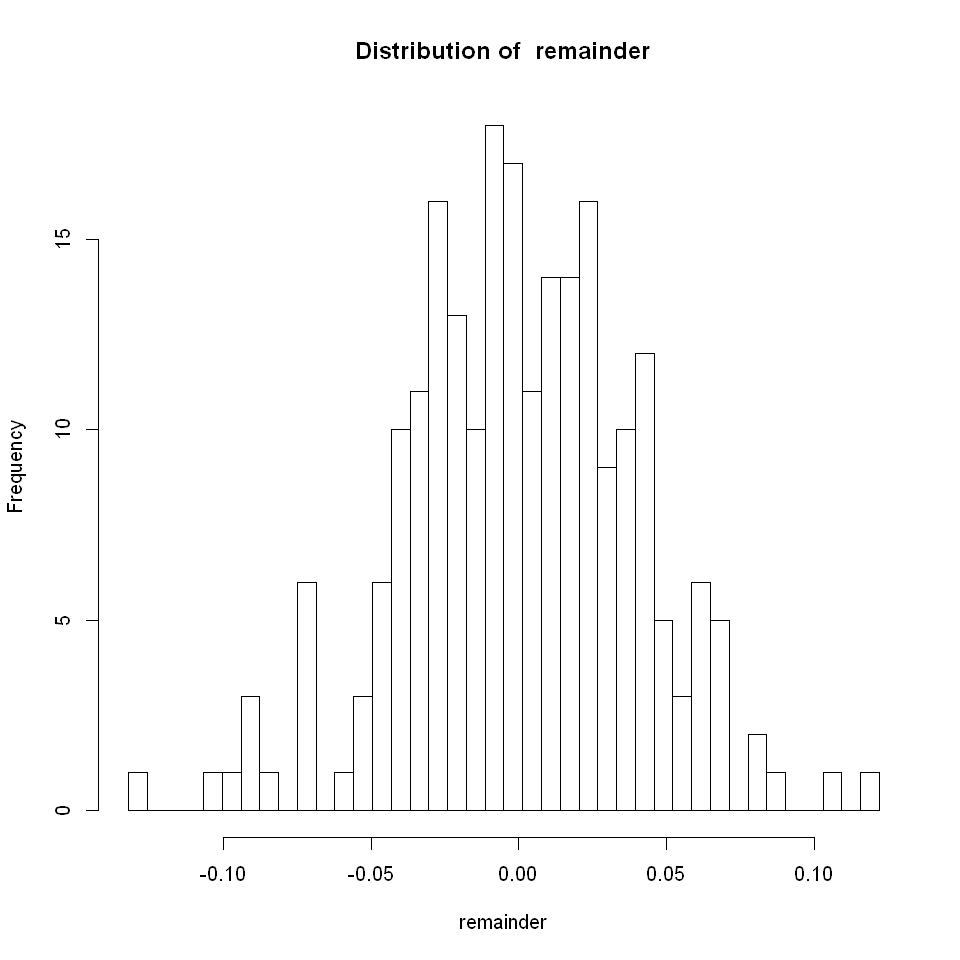

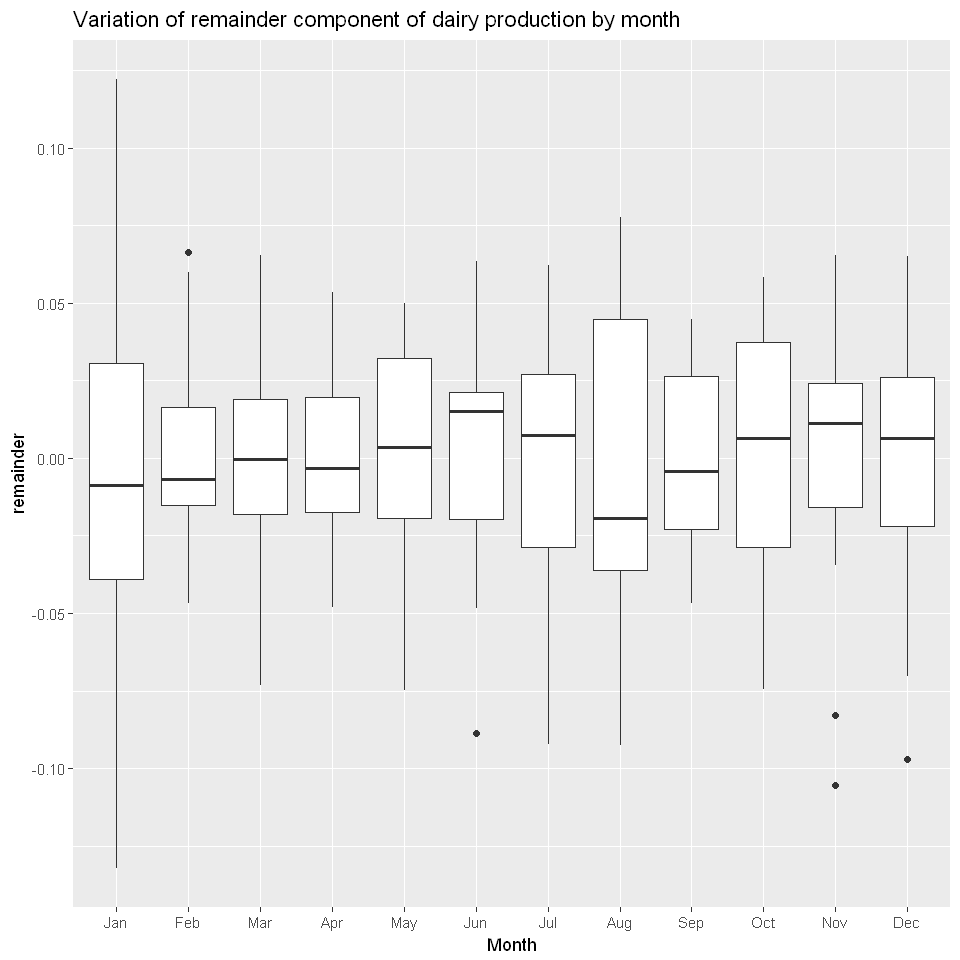

In [31]:
dairyMult2 = dairy.decomp(dairy, col = 'Icecream.Prod', span = 0.2)
dairy.acf(dairyMult2)
hist.ts(dairyMult2, col = 'remainder')
dairy.box(dairyMult2)

## Moving Average Models

Now that you have explored the decomposition of the time series you, will now construct and test Autoregressive Moving Average (ARMA) models for the remainder of the time series. You will create and test these models in three steps, creating a moving average (MA) model, creating an autoregressive (AR) model and creating an autoregressive moving average (ARMA) model. 

The function in the cell below computes an Autoregressive Integrative Moving Average (ARIMA) model. The summary statistics for the model are printed and the model object returned. By assigning values to the order of each operator different time series models can be specified, as order of MA model, order of Integrative model, and order of AR model. Since the de-trended remainder is being modeled, the **include.mean** argument is set to FALSE in the **arima** function. 

The ACF of the remainder from the **stl** decomposition of the milk production time series had 4 significant lag values. As an inital model, you will now create an MA model of order 4. Execute the code in the cell below to compute the MA(4) model and examine the model summary. 

In [32]:
model.dairy = function(df, col = 'remainder', order = c(0,0,1)){
  ts = ts(df[, col], frequency = 12, start = 1995)
  dairy.mod = arima(ts, order = order, include.mean = FALSE)
  print(dairy.mod)
  dairy.mod
}
ma1 = model.dairy(dairyMult, order = c(0,0,4))


Call:
arima(x = ts, order = order, include.mean = FALSE)

Coefficients:
         ma1     ma2     ma3     ma4
      0.7259  0.5308  0.2976  0.0193
s.e.  0.0659  0.0776  0.0748  0.0589

sigma^2 estimated as 0.0001876:  log likelihood = 654.34,  aic = -1298.67


Examine the values of the model coefficients and their standard errors (SE). Notice that the SE of the ma4 coefficient is actually greater than the value of the coefficient itself. This indicates that the value of this coefficient is poorly deterimind and should likely be set to zero. 

The foregoing result indicates that the order of the MA model should be reduced. Generally, the order of an MA model is reduced in unit steps until all the coefficients appear to be significant. The code in the cell below computes an MA(3) model. Run this code and examine the model summary. 

In [33]:
ma1 = model.dairy(dairyMult, order = c(0,0,3))


Call:
arima(x = ts, order = order, include.mean = FALSE)

Coefficients:
         ma1     ma2     ma3
      0.7224  0.5211  0.2861
s.e.  0.0645  0.0698  0.0660

sigma^2 estimated as 0.0001877:  log likelihood = 654.28,  aic = -1300.56


The small standard error compared to the magnitude of the coefficients indicates that the order of the model is reasonable. 

To test how well this model fits the data, and results in a stationary result, you will plot the ACF of the residuals of the MA(3) model. Run the code in the cell below to plot the ACF of the model result. 

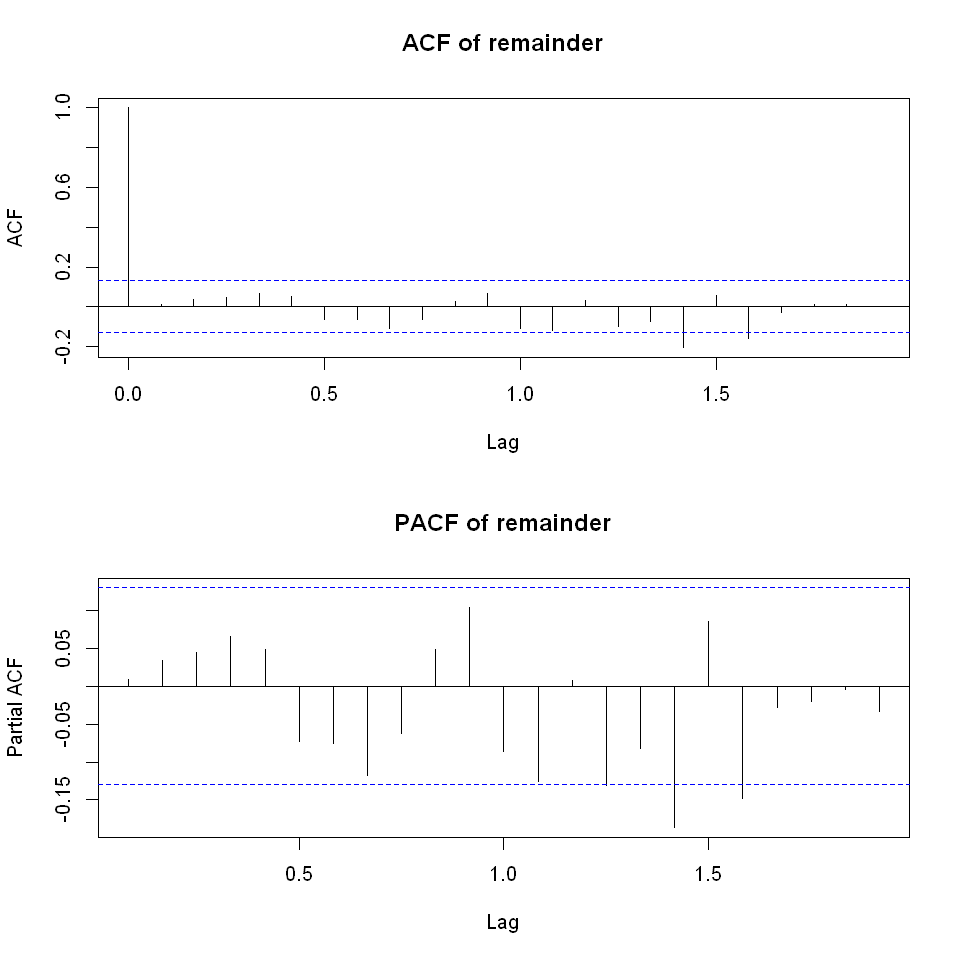

In [34]:
dairy.acf(ma1$resid[-1], is.df = FALSE)

Note that only the 0 lag of the ACF is significant and that there are no significant lags for the PACS. These observations indicate that the MA(3) model is a good fit. 

## Autoregressive Models

The MA(3) model has been shown to be effective. Next, you will test an autoregressive model. The PACF of the reminder indicates that an AR model might not be the best choice. None the less, a low order AR model might fit these data. To compute an AR(2) model exectue the code in the cell below. 

In [35]:
ar1 = model.dairy(dairyMult, order = c(2,0,0))


Call:
arima(x = ts, order = order, include.mean = FALSE)

Coefficients:
         ar1      ar2
      0.7148  -0.0288
s.e.  0.0665   0.0665

sigma^2 estimated as 0.0001899:  log likelihood = 653.04,  aic = -1300.08


Examine the values of the coefficients and their standard errors. Note that the standard error of the second coefficient is of the same magnitude as the coefficient. Clearly, the AR(2) model is over parameterized. 

Next, you will try an AR(1) model, by executing the code in the cell below.

In [36]:
ar1 = model.dairy(dairyMult, order = c(1,0,0))


Call:
arima(x = ts, order = order, include.mean = FALSE)

Coefficients:
         ar1
      0.6946
s.e.  0.0475

sigma^2 estimated as 0.00019:  log likelihood = 652.95,  aic = -1301.9


The standard error of the AR(1) model is an order of magnitude less than the value of the coefficient, which is promising.

Next, exectue the code in the cell below to plot the ACF and PACF of the AR(1) model

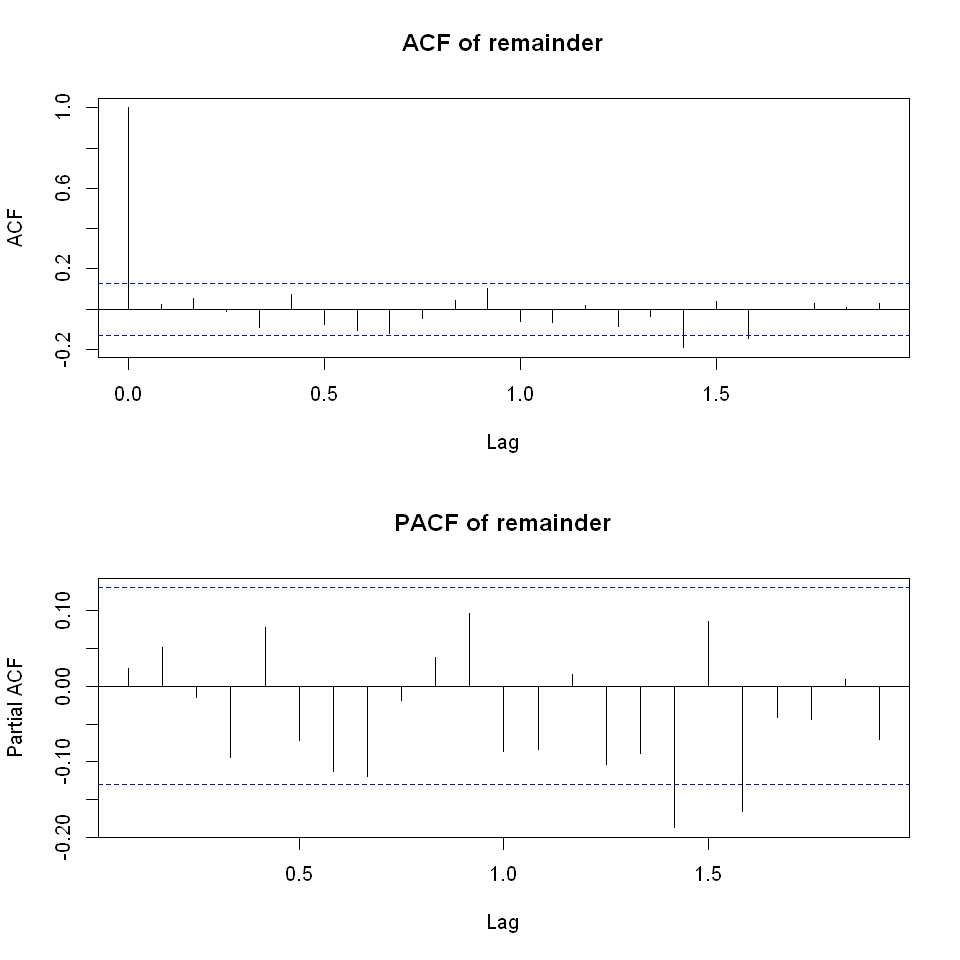

In [37]:
options(repr.plot.width=8, repr.plot.height=8)
dairy.acf(ar1$resid[-1], is.df = FALSE)

Note that only the 0 lag of the ACF is significant and that there are no significant lags for the PACF. These observations indicate that the AR(1) model is a good fit. Compare these results to those of the MA(3) model, noting that they are nearly identical. Evidently, either the MA(3) or AR(1) model is a good choice for these data. 

## Autoregressive Moving Average Models

You have found that both MA(3) and AR(1) models are good fits to the remainder series. You will now investigate the use of autoregressive moving average (ARMA) models on the remainder series. 

As a starting point you will try an ARMA(1,3) model by executing the code in the cell below. 

In [38]:
arma1 = model.dairy(dairyMult, order = c(1,0,3))


Call:
arima(x = ts, order = order, include.mean = FALSE)

Coefficients:
         ar1     ma1     ma2     ma3
      0.1532  0.5750  0.4288  0.2274
s.e.  0.3874  0.3889  0.2588  0.1805

sigma^2 estimated as 0.0001876:  log likelihood = 654.39,  aic = -1298.78


In each case, the standard error is of the same order of magnitude as the value of the coefficient, indicating this model is a poor fit to the data.


****

### Exercise: Test Another ARMA Model

In this exercise you will test an ARMA(1,1) model and evaluate its coefficients to answer these questions. 

- How do the standard errors compare to the values of the coefficients?
- Do you think this model fits the data well or is it over parameterize?

Add code to compute the ARMA(1,1) model and plot iots ACFG and PACF to the cell below, and answer the questions above.

****


Call:
arima(x = ts, order = order, include.mean = FALSE)

Coefficients:
         ar1     ma1
      0.6777  0.0330
s.e.  0.0661  0.0856

sigma^2 estimated as 0.0001899:  log likelihood = 653.02,  aic = -1300.05


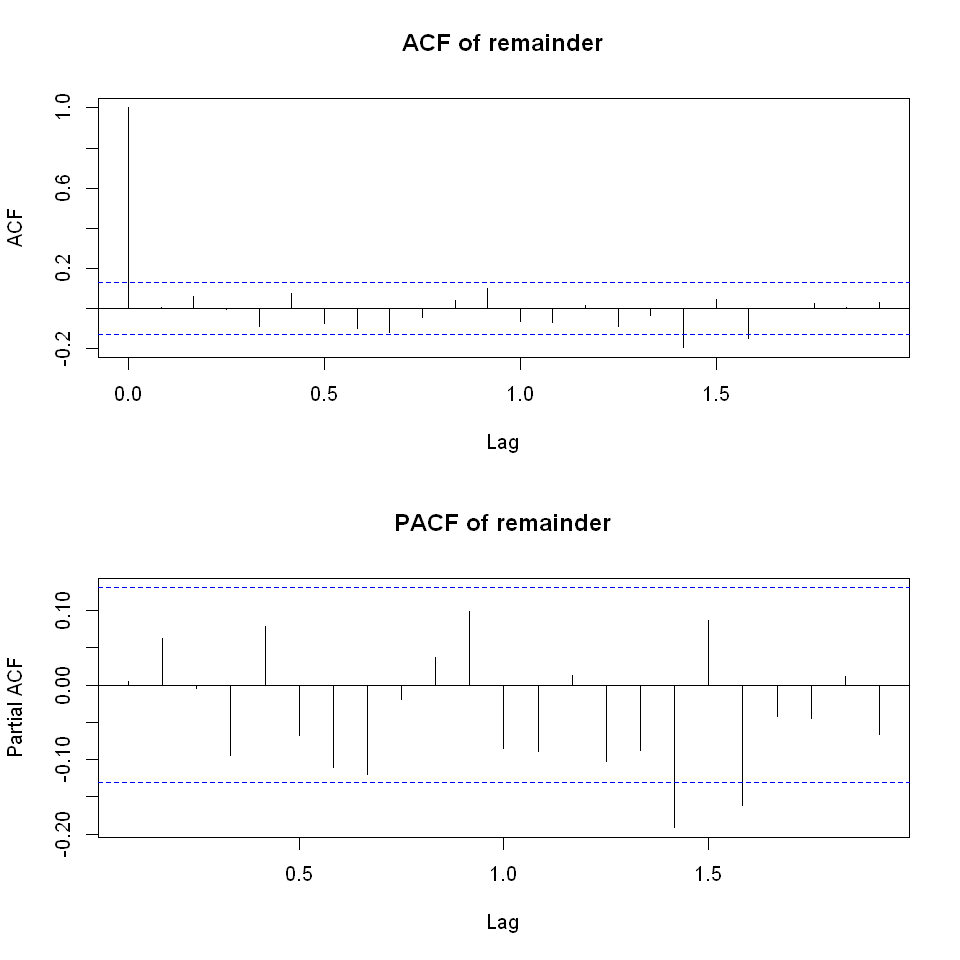

In [40]:
arma2 = model.dairy(dairyMult, order = c(1,0,1))
dairy.acf(arma2$resid[-1], is.df = FALSE)


## Exploring the Difference Series

Using a difference series is a method to remove trend from a time series. The difference can be computed for any number of lag values, depending on the order of the trend.  In this case you will use a first order difference series to model the trend in the milk production time series. 

Using the code in the cell below, you will compute the first order difference series. Notice that the difference series is  necessarily of length one less than the original series. Execute the code in the cell to compute the difference series. 

In [41]:
dairy.diff <- function(df, col = 'Milk.Prod', out = 'Milk.Diff'){
  ln <- nrow(df)
  temp <- ts(df[, col], frequency = 12, start = 1995)
  df[2:ln, out] <- diff(temp)
  df <- df[2:ln, ]
  df
}
dairyDiff <- dairy.diff(dairy)

Next, compute the stl decomposition of the difference series. Since we are working with a difference series, which has positive and negative values, we use an additive model. No logarithm is taken. Execute the code in the cell below to compute and display the decomposition of the difference series.  

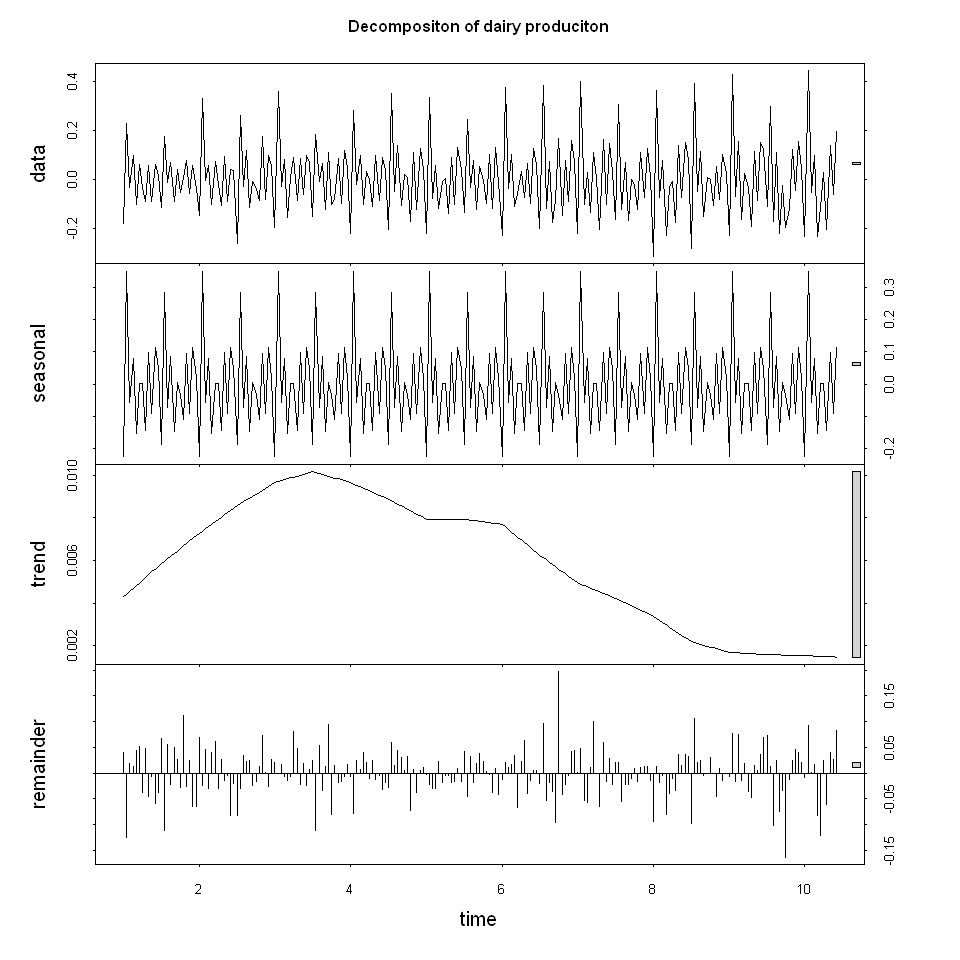

In [42]:
dairyDiff = dairy.decomp(dairyDiff, col = 'Milk.Diff', span = 0.5, Mult = FALSE)

Examine the results shown above. The difference series is shown in the uppermost plot. Notice the small magnitude of the remaining trend indicating that the first order difference model removed most of the trend. However, the seasonal series exhibits a pattern with a 24 month cycle which is a bit odd. 

****

### Exercise: Analysis of the Difference Series

In this exercise you will analyize the remainder of the difference series following these steps. 

- Does the acf plot indicate that the remainder series is stationary?  
- Is the dispersion of these values greater or less than the dispersion obtained directly from the decomposition of the time series (without diferencing). 
- Is the interquartile range of these values greater or less than the interquartile range obtained directly from the decomposition of the time series (without differencing). 

In the code cell below, use the **dairy.acf**, **dairy.hist**, and **dairy.box** functions to create new plots of the difference series and answer the questions above. 
****


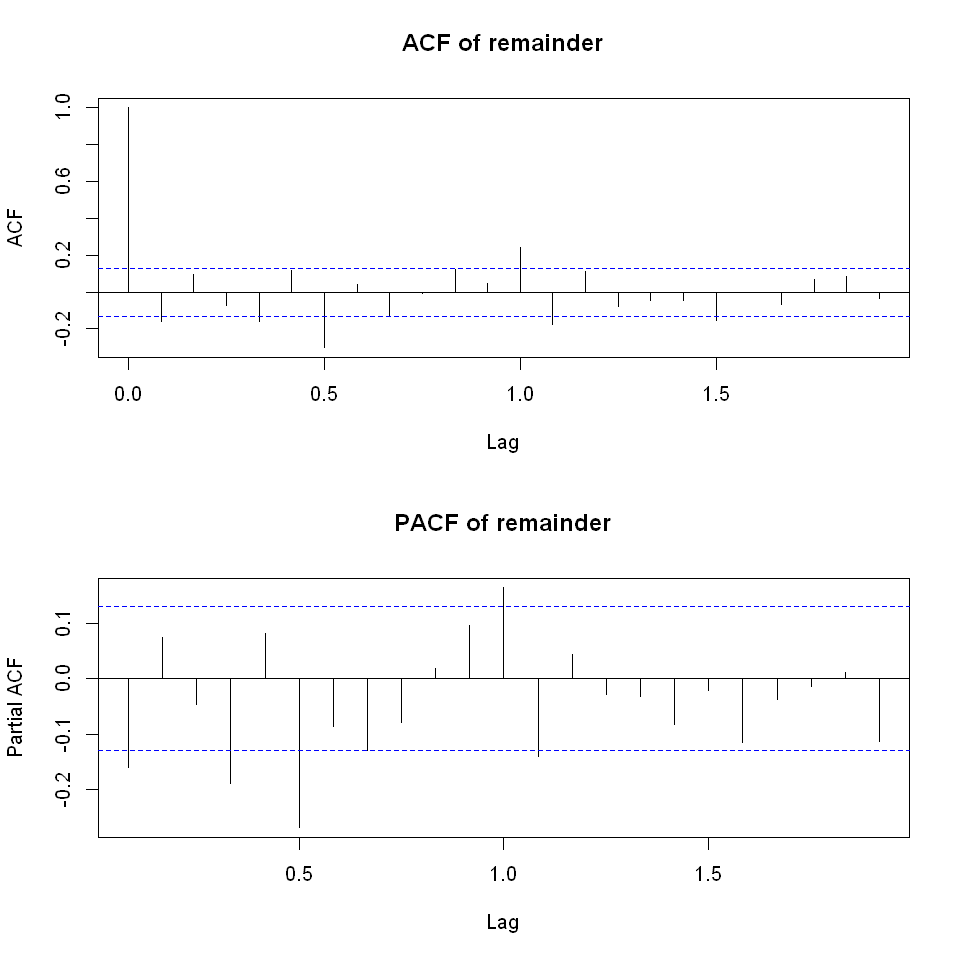

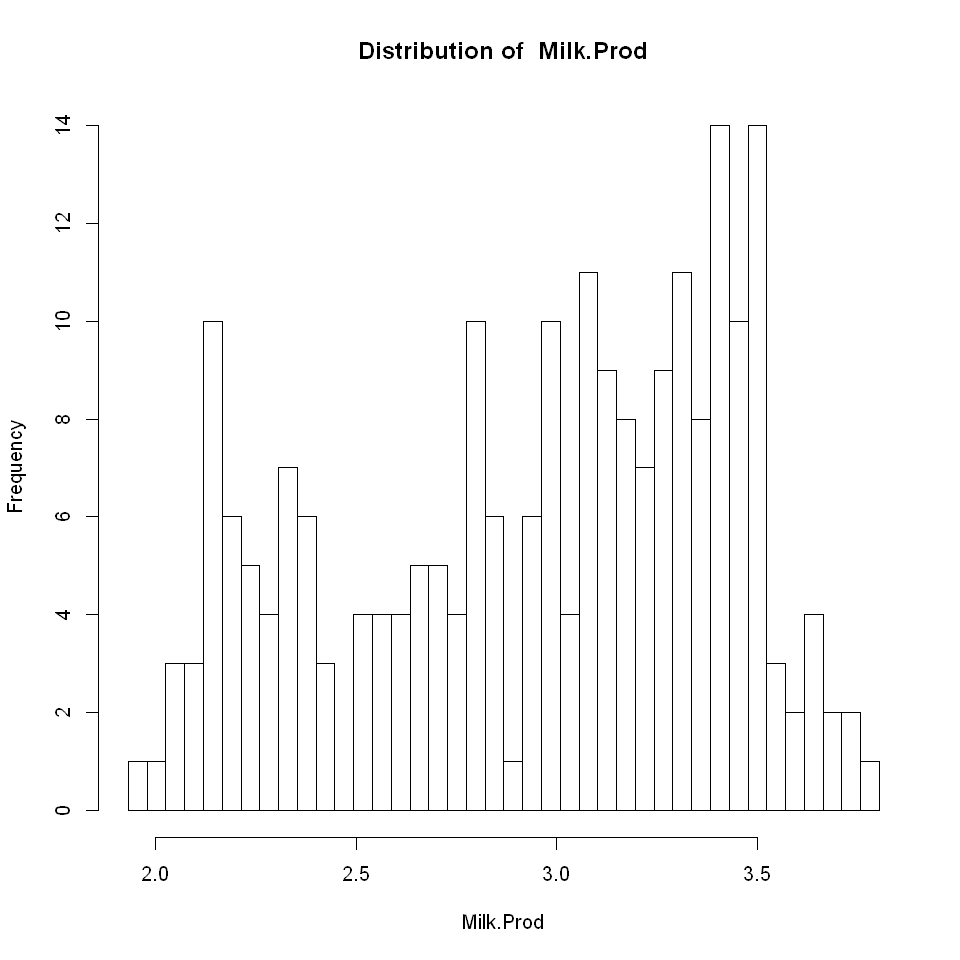

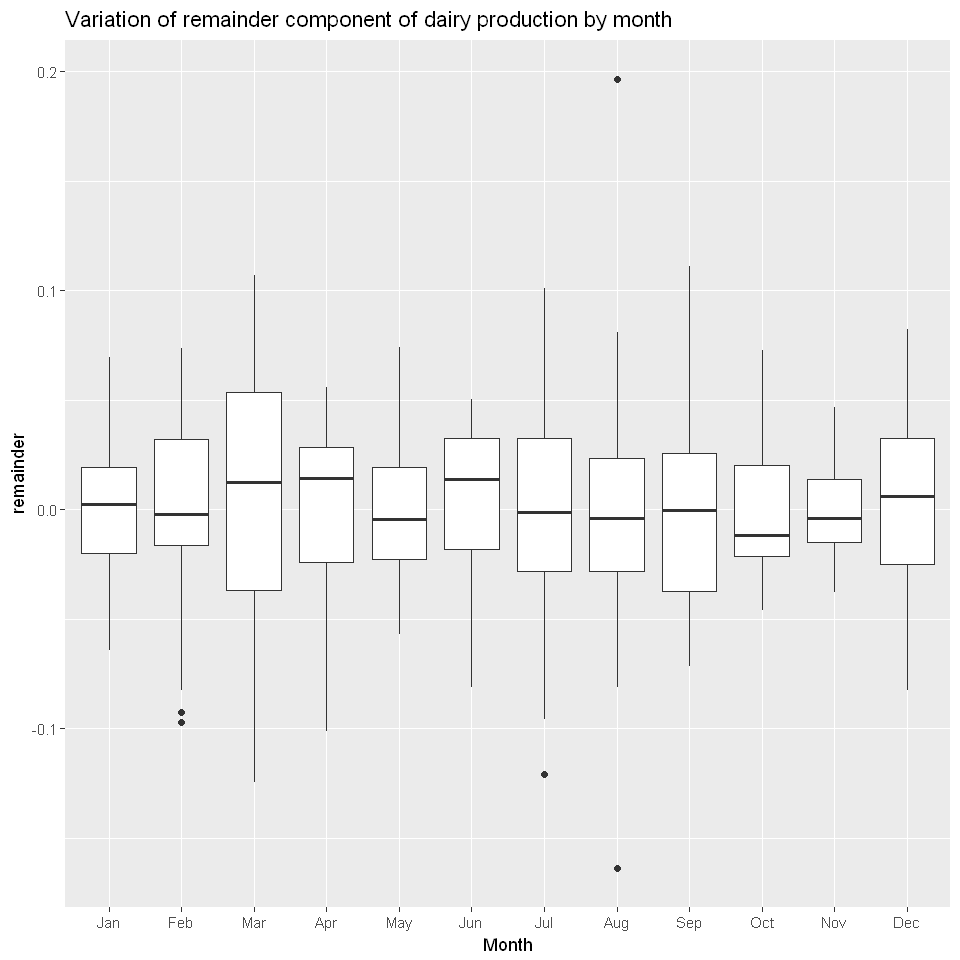

In [44]:
dairy.acf(dairyDiff)
hist.ts(dairyDiff)
dairy.box(dairyDiff)

## Autoregressive Integrative Moving Average Model

It is clear from the exploration of the ARMA model, that the remainder of the decomposition of the dairy production time series is not stationary. You will now model the remainder series with an autoregressive integrative moving average (ARIMA) model.

Execute the code in the cell below to compute an ARIMA(1,1,1) model.

In [45]:
arima1 = model.dairy(dairyMult, order = c(1,1,1))


Call:
arima(x = ts, order = order, include.mean = FALSE)

Coefficients:
         ar1      ma1
      0.7015  -1.0000
s.e.  0.0482   0.0114

sigma^2 estimated as 0.0001908:  log likelihood = 648.11,  aic = -1290.22


The standard error of the ar1 coeficient is only about half its value. This model seems to be a reasonable fit. 

Next, plot the ACF and PACF of the model by executing the code in the cell below. 

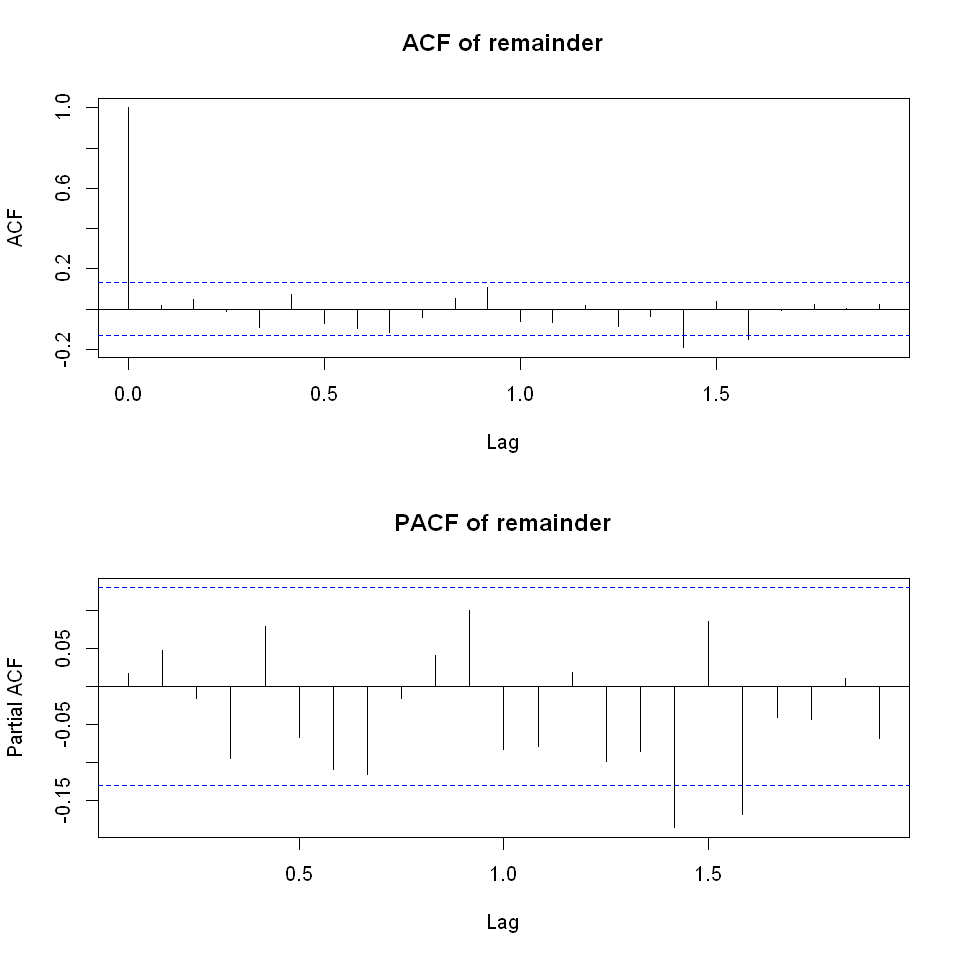

In [46]:
dairy.acf(arima1$resid[-1], is.df = FALSE)

Note that only the 0 lag of the ACF is significant and that there are no significant lags for the PACF. These observations indicate that the ARIMA(1,1,1) model is a good fit. Compare these results to those of the MA(3) and AR(1) models, noting that they are nearly identical. The ARIMA(1,1,1) model is a good choice for these data as well. 


## Modeling and Forecasting

Now that you have explored the properties of the decomposed time series, you will now compute forecasts of dairy product production. In this exercise you will compute a time series model using the R **forecast** package, and use this model to forecast the next 12 months of dairy product production. 

The R **forecast** package contains the **auto.arima** function which automatically steps through the ARIMA model parameters to find the best fit to the data. The ARIMA model used in the **forecast** package also includes modeling of seasonal differences.  The **auto.arima** function has multiple arguments, specifying the range of parameter values to search. The first argument is a time series object of class **ts**. 

The code in the cell below does the following:

- Creates a time series of class **ts**.
- Automatically finds and computes an ARIMA model.
- Prints a summary of the ARIMA model.

Execute the code in the cell below to compute and print the summary of the ARIMA model. 

In [47]:
temp <- ts(log(dairy[, 'Milk.Prod']), frequency=12, start=1995)
#install.packages("forecast")
library(forecast)
fit.dairy = auto.arima(temp, max.p=3, max.q=3,
      max.P=2, max.Q=2, max.order=5, max.d=2, max.D=1,
      start.p=0, start.q=0, start.P=0, start.Q=0)
summary(fit.dairy)

Warning message:
"package 'forecast' was built under R version 3.4.3"

Series: temp 
ARIMA(0,1,1)(0,1,2)[12] 

Coefficients:
          ma1     sma1    sma2
      -0.1506  -0.9076  0.1129
s.e.   0.0743   0.0794  0.0838

sigma^2 estimated as 0.0002584:  log likelihood=577.8
AIC=-1147.6   AICc=-1147.41   BIC=-1134.12

Training set error measures:
                        ME       RMSE        MAE         MPE    MAPE      MASE
Training set -0.0003536657 0.01549906 0.01109068 -0.01955938 1.05342 0.2902694
                    ACF1
Training set 0.005145456


Examine the summary of the model, noticing the following points.

- The model uses an MA(2) model for the seasonal difference. The coefficients of this model, sma1 and sma2, along with their standard errors can be seen in the summary.
- The model of the remainder is and MA(1) model. The coeficient and its standard error can be seen in the summary above. 
- Error metrics, including RMSE, are provided in the summary. Notice that the RMSE is much smaller than the values of the milk production time series indicating good model performance.

The **forecast** function is used to compute the forecast of the next 12 months using the model created using **auto.arima**. Execute the code in the cell below to compute a forecast and print its summary. 

In [48]:
dairy.fit = forecast(fit.dairy, h=12)
summary(dairy.fit)


Forecast method: ARIMA(0,1,1)(0,1,2)[12]

Model Information:
Series: temp 
ARIMA(0,1,1)(0,1,2)[12] 

Coefficients:
          ma1     sma1    sma2
      -0.1506  -0.9076  0.1129
s.e.   0.0743   0.0794  0.0838

sigma^2 estimated as 0.0002584:  log likelihood=577.8
AIC=-1147.6   AICc=-1147.41   BIC=-1134.12

Error measures:
                        ME       RMSE        MAE         MPE    MAPE      MASE
Training set -0.0003536657 0.01549906 0.01109068 -0.01955938 1.05342 0.2902694
                    ACF1
Training set 0.005145456

Forecasts:
         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Jan 2014       1.259101 1.238502 1.279700 1.227598 1.290605
Feb 2014       1.193990 1.166963 1.221016 1.152656 1.235324
Mar 2014       1.303803 1.271607 1.335999 1.254564 1.353043
Apr 2014       1.278470 1.241827 1.315113 1.222429 1.334511
May 2014       1.307799 1.267193 1.348405 1.245697 1.369900
Jun 2014       1.256228 1.212012 1.300443 1.188606 1.323849
Jul 2014       1.253456 1.205904 1.3

Much of the summary is the same as before. A 12 month forecast is printed below the model summary. There is a point forecast (the expected value) along with 80 and 95 percent confidence intervals. Notice, that the confidence intervals generally get wider for forecasts further out in time. It is hardly suprising that the forecast has more uncertaintly as time increases from the present. 

Finally, you can plot the forecast by executing the code in the cell below. 

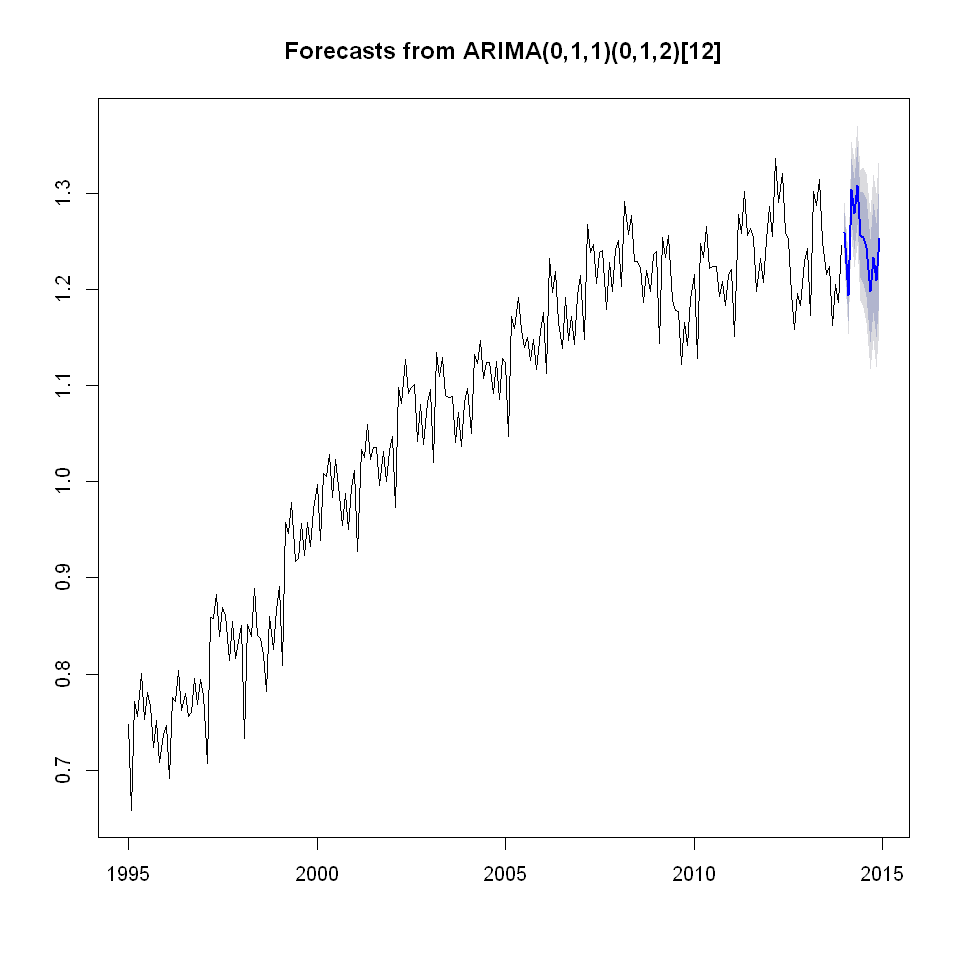

In [49]:
plot(dairy.fit)

The original time series of milk production is show in black in the plot above. The forecast is show in Blue. The 80 and 95 percent confidence intervals are shown in lighter shades of blue-gray.  

****

### Exercise: Forecast Ice Cream Production

In this exercise you will forecast the production of icecream for a 12 month period following these steps. 

- Create a time series object with **frequency = 12** and **start = 1995** from the **Icecream.Prod** column of the **dairy** data frame.
- Fit a model with the **auto.arima** function, following the hint given below.
- Print a summary of the model. What is the order of the MA and AR components of the seasonal and remainder models? Note there will be a drift term, which accounts for linear trend in the time series.
- Compute the forecast of icecream production for the next 12 months. 
- Plot the forecast and note the behavior. 

In the code cell below, use the **ts**, **auto.arima**, **summary**, **forecast**, and **plot** functions to create the new model, print the summaries and make the plots. **Hint** use the time series of icecream production as the first argument to the **auto.arima** function. You can copy and paste the other arguments from the milk production model, but set **max.p = 1** to prevent having an over-parameterized model. 

****


Series: temp2 
ARIMA(3,0,1)(0,1,2)[12] with drift 

Coefficients:
          ar1     ar2     ar3     ma1     sma1     sma2  drift
      -0.1996  0.1658  0.3746  0.4086  -0.5043  -0.2039  6e-04
s.e.   0.1767  0.0755  0.0636  0.1925   0.0699   0.0672  2e-04

sigma^2 estimated as 0.001583:  log likelihood=389.7
AIC=-763.4   AICc=-762.7   BIC=-736.4

Training set error measures:
                      ME       RMSE        MAE        MPE      MAPE      MASE
Training set 0.001360524 0.03809705 0.02972694 0.02906281 0.7001261 0.7583233
                     ACF1
Training set -0.004410837

Forecast method: ARIMA(3,0,1)(0,1,2)[12] with drift

Model Information:
Series: temp2 
ARIMA(3,0,1)(0,1,2)[12] with drift 

Coefficients:
          ar1     ar2     ar3     ma1     sma1     sma2  drift
      -0.1996  0.1658  0.3746  0.4086  -0.5043  -0.2039  6e-04
s.e.   0.1767  0.0755  0.0636  0.1925   0.0699   0.0672  2e-04

sigma^2 estimated as 0.001583:  log likelihood=389.7
AIC=-763.4   AICc=-762.7   BIC=-7

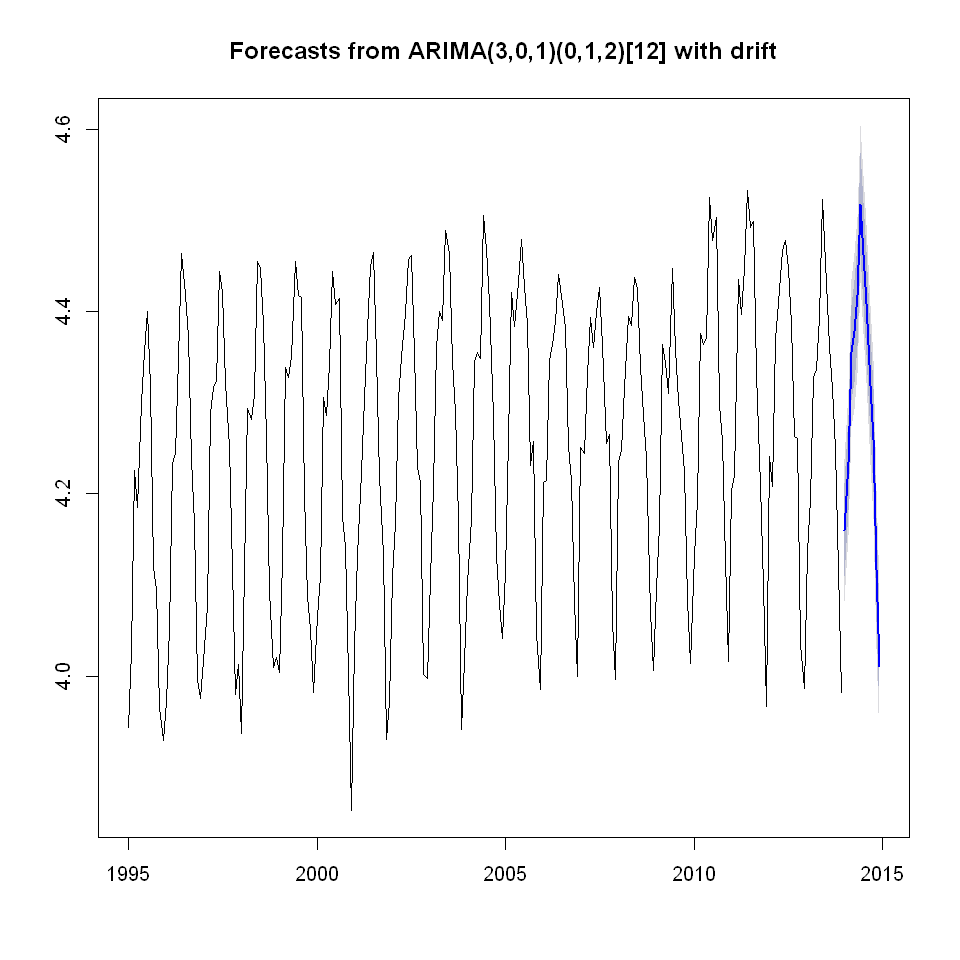

In [50]:
temp2 <- ts(log(dairy[, 'Icecream.Prod']), frequency=12, start=1995)
#install.packages("forecast")
library(forecast)
fit.dairy = auto.arima(temp2, max.p=3, max.q=3,
      max.P=1, max.Q=2, max.order=5, max.d=2, max.D=1,
      start.p=0, start.q=0, start.P=0, start.Q=0)
summary(fit.dairy)
dairy.fit = forecast(fit.dairy, h=12)
summary(dairy.fit)
plot(dairy.fit)

## Summary

In this lab you have learned to work with and analyze time series data. Specifically, you have done the following:

- Examined the properties of time series objects.
- Plotted time series data.
- Decomposed time series data into its trend, seasonal, and remainder components.
- Modeled the remainder components as AR, MA, ARMA and ARIMA models. 
- Created and evaluated difference series methods.
- Constructed and evaluated a forecasting model. 